In [1]:
import pandas as pd

# 사용자 데이터 로드
users_df = pd.read_csv("/content/drive/MyDrive/DataA_dev/Airbnb_new_user_booking/train_users_2.csv")

# 나이 필터링
users_df = users_df[(users_df['age'] >= 18) & (users_df['age'] <= 122)]

# 성별 필터링
users_df['gender'] = users_df['gender'].replace({'-unknown-': 'ufs'})

# 초기 유입 경로 필터링
users_df['first_affiliate_tracked'] = users_df['first_affiliate_tracked'].fillna('untracked')

# 날짜 데이터를 DateTime 형식으로 변환
users_df['date_account_created'] = pd.to_datetime(users_df['date_account_created'])
users_df['timestamp_first_active'] = pd.to_datetime(users_df['timestamp_first_active'], format='%Y%m%d%H%M%S')

# object 타입을 category로 변환
categorical_columns = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for col in categorical_columns:
    users_df[col] = users_df[col].astype('category')

# 결과 확인
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124522 entries, 1 to 213448
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       124522 non-null  object        
 1   date_account_created     124522 non-null  datetime64[ns]
 2   timestamp_first_active   124522 non-null  datetime64[ns]
 3   date_first_booking       68134 non-null   object        
 4   gender                   124522 non-null  category      
 5   age                      124522 non-null  float64       
 6   signup_method            124522 non-null  category      
 7   signup_flow              124522 non-null  category      
 8   language                 124522 non-null  category      
 9   affiliate_channel        124522 non-null  category      
 10  affiliate_provider       124522 non-null  category      
 11  first_affiliate_tracked  124522 non-null  category      
 12  signup_app           

In [2]:

sessions_df = pd.read_csv('/content/drive/MyDrive/DataA_dev/Airbnb_new_user_booking/sessions.csv')
sessions_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [3]:
# object 타입을 category로 변환
categorical_columns_sessions = ['action', 'action_type', 'action_detail', 'device_type']
for col in categorical_columns_sessions:
    sessions_df[col] = sessions_df[col].astype('category')

# 결과 확인
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype   
---  ------         -----   
 0   user_id        object  
 1   action         category
 2   action_type    category
 3   action_detail  category
 4   device_type    category
 5   secs_elapsed   float64 
dtypes: category(4), float64(1), object(1)
memory usage: 221.7+ MB


In [4]:
sessions_df

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In [13]:
# 사용자 데이터의 'id' 열 이름을 'user_id'로 변경
users_df.rename(columns={'id': 'user_id'}, inplace=True)

# 사용자 데이터에 예약 여부 컬럼 추가 (예: 'booked' 컬럼)
users_df['booked'] = ~users_df['date_first_booking'].isnull()


merged_df = sessions_df.merge(users_df, left_on='user_id', right_on='user_id', how='inner')
# 세션 타임스탬프 생성
merged_df['session_timestamp'] = merged_df['timestamp_first_active'] + pd.to_timedelta(merged_df['secs_elapsed'].fillna(0), unit='s')

# 예약 여부를 고려한 DAU 계산
merged_df['date'] = merged_df['session_timestamp'].dt.date
dau = merged_df.groupby(['date', 'affiliate_channel', 'device_type', 'booked'])['user_id'].nunique().reset_index()
dau.columns = ['date', 'affiliate_channel', 'device_type', 'booked', 'DAU']

# 예약 전환율 계산
dau_pivot = dau.pivot_table(index=['date', 'affiliate_channel', 'device_type'], columns='booked', values='DAU', fill_value=0).reset_index()
dau_pivot.columns = ['date', 'affiliate_channel', 'device_type', 'DAU_not_booked', 'DAU_booked']
dau_pivot['conversion_rate'] = dau_pivot['DAU_booked'] / (dau_pivot['DAU_booked'] + dau_pivot['DAU_not_booked'])
dau_pivot['conversion_rate'].fillna(0, inplace=True)

# 결과 확인
dau_pivot

,date,affiliate_channel,device_type,DAU_not_booked,DAU_booked,conversion_rate
0,2014-01-01,api,-unknown-,9,3,0.25
1,2014-01-01,api,Android App Unknown Phone/Tablet,2,2,0.50
2,2014-01-01,api,Android Phone,0,0,0.00
3,2014-01-01,api,Blackberry,0,0,0.00
4,2014-01-01,api,Chromebook,0,0,0.00
...,...,...,...,...,...,...
22619,2014-07-21,seo,Windows Desktop,0,0,0.00
22620,2014-07-21,seo,Windows Phone,0,0,0.00
22621,2014-07-21,seo,iPad Tablet,0,0,0.00
22622,2014-07-21,seo,iPhone,0,0,0.00


In [7]:
# 예약 여부를 고려한 WAU 계산
merged_df['week'] = merged_df['session_timestamp'].dt.to_period('W').apply(lambda r: r.start_time)
wau = merged_df.groupby(['week', 'affiliate_channel', 'device_type', 'booked'])['user_id'].nunique().reset_index()
wau.columns = ['week_start', 'affiliate_channel', 'device_type', 'booked', 'WAU']

# 예약 전환율 계산
wau_pivot = wau.pivot_table(index=['week_start', 'affiliate_channel', 'device_type'], columns='booked', values='WAU', fill_value=0).reset_index()
wau_pivot.columns = ['week_start', 'affiliate_channel', 'device_type', 'WAU_not_booked', 'WAU_booked']
wau_pivot['conversion_rate'] = wau_pivot['WAU_booked'] / (wau_pivot['WAU_booked'] + wau_pivot['WAU_not_booked'])
wau_pivot['conversion_rate'].fillna(0, inplace=True)

# 결과 확인
wau_pivot

,week_start,affiliate_channel,device_type,WAU_not_booked,WAU_booked,conversion_rate
0,2013-12-30,api,-unknown-,56,34,0.377778
1,2013-12-30,api,Android App Unknown Phone/Tablet,12,8,0.400000
2,2013-12-30,api,Android Phone,0,0,0.000000
3,2013-12-30,api,Blackberry,0,0,0.000000
4,2013-12-30,api,Chromebook,0,0,0.000000
...,...,...,...,...,...,...
3355,2014-07-21,seo,Windows Desktop,0,0,0.000000
3356,2014-07-21,seo,Windows Phone,0,0,0.000000
3357,2014-07-21,seo,iPad Tablet,0,0,0.000000
3358,2014-07-21,seo,iPhone,0,0,0.000000


In [9]:
# 예약 여부를 고려한 MAU 계산
merged_df['month'] = merged_df['session_timestamp'].dt.to_period('M').apply(lambda r: r.start_time)
mau = merged_df.groupby(['month', 'affiliate_channel', 'device_type', 'booked'])['user_id'].nunique().reset_index()
mau.columns = ['month_start', 'affiliate_channel', 'device_type', 'booked', 'MAU']

# 예약 전환율 계산
mau_pivot = mau.pivot_table(index=['month_start', 'affiliate_channel', 'device_type'], columns='booked', values='MAU', fill_value=0).reset_index()
mau_pivot.columns = ['month_start', 'affiliate_channel', 'device_type', 'MAU_not_booked', 'MAU_booked']
mau_pivot['conversion_rate'] = mau_pivot['MAU_booked'] / (mau_pivot['MAU_booked'] + mau_pivot['MAU_not_booked'])
mau_pivot['conversion_rate'].fillna(0, inplace=True)

# 결과 확인
mau_pivot

,month_start,affiliate_channel,device_type,MAU_not_booked,MAU_booked,conversion_rate
0,2014-01-01,api,-unknown-,368,197,0.348673
1,2014-01-01,api,Android App Unknown Phone/Tablet,105,55,0.343750
2,2014-01-01,api,Android Phone,3,4,0.571429
3,2014-01-01,api,Blackberry,0,0,0.000000
4,2014-01-01,api,Chromebook,0,0,0.000000
...,...,...,...,...,...,...
779,2014-07-01,seo,Windows Desktop,11,23,0.676471
780,2014-07-01,seo,Windows Phone,0,0,0.000000
781,2014-07-01,seo,iPad Tablet,2,9,0.818182
782,2014-07-01,seo,iPhone,4,4,0.500000


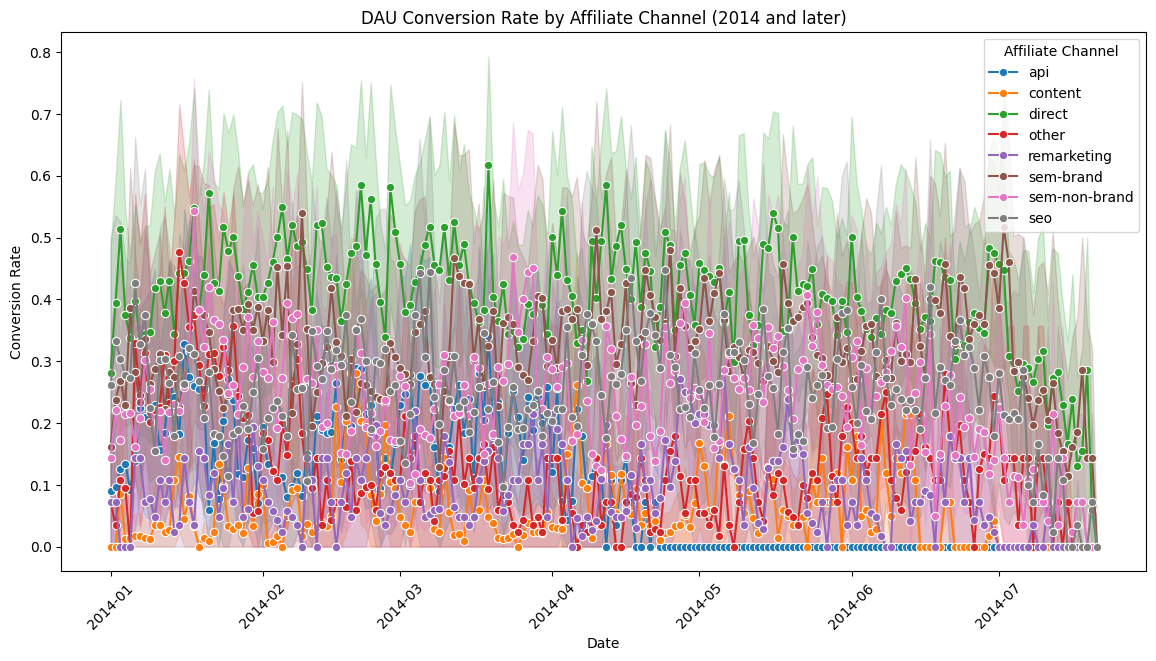

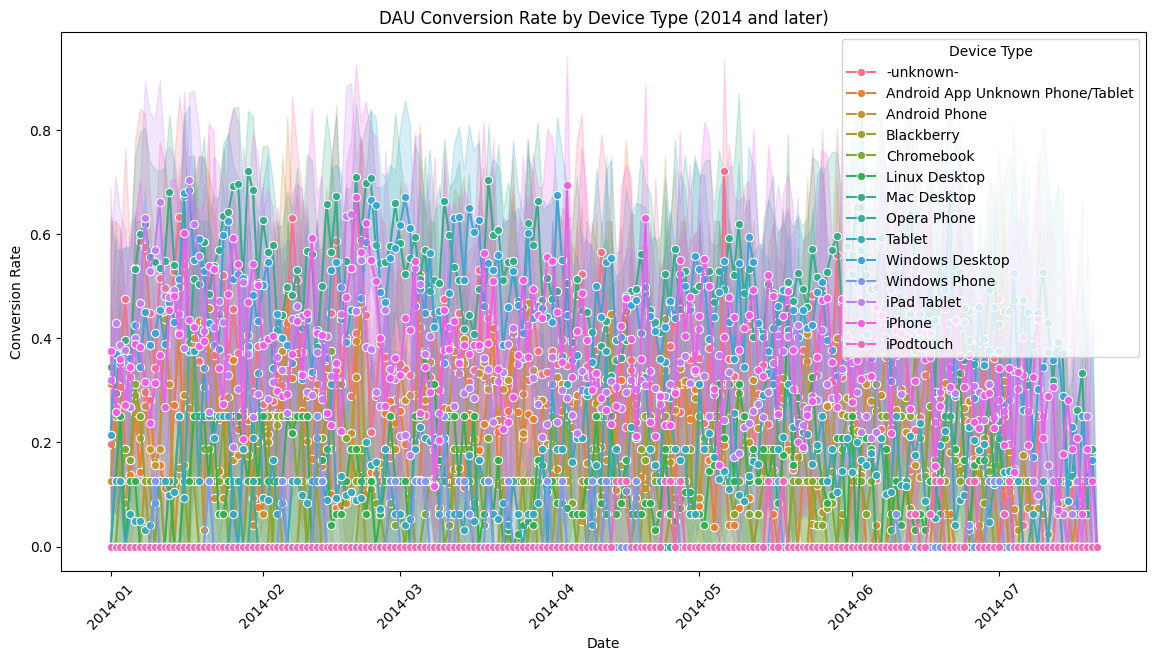

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜 데이터를 datetime 형식으로 변환
dau_pivot['date'] = pd.to_datetime(dau_pivot['date'])

# 2014년 이후의 데이터 필터링
dau_pivot_2014 = dau_pivot[dau_pivot['date'] >= '2014-01-01']

# DAU 전환율 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(data=dau_pivot_2014, x='date', y='conversion_rate', hue='affiliate_channel', marker='o')
plt.title('DAU Conversion Rate by Affiliate Channel (2014 and later)')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend(title='Affiliate Channel')
plt.xticks(rotation=45)
plt.show()

# device type별 DAU 전환율 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(data=dau_pivot_2014, x='date', y='conversion_rate', hue='device_type', marker='o')
plt.title('DAU Conversion Rate by Device Type (2014 and later)')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend(title='Device Type')
plt.xticks(rotation=45)
plt.show()


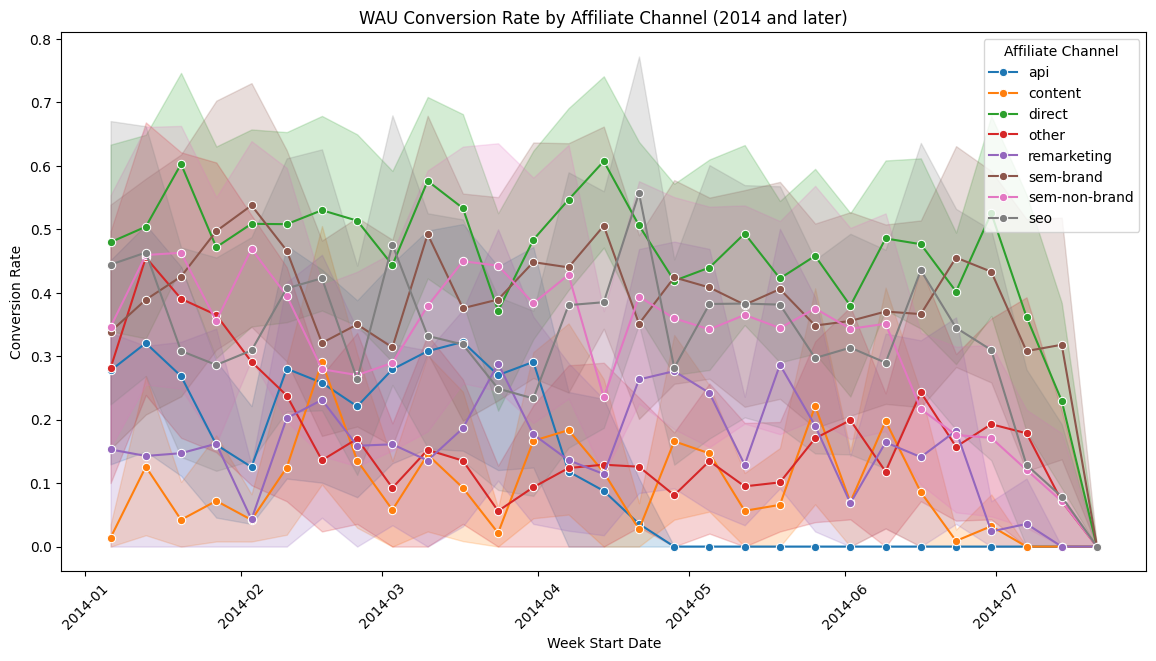

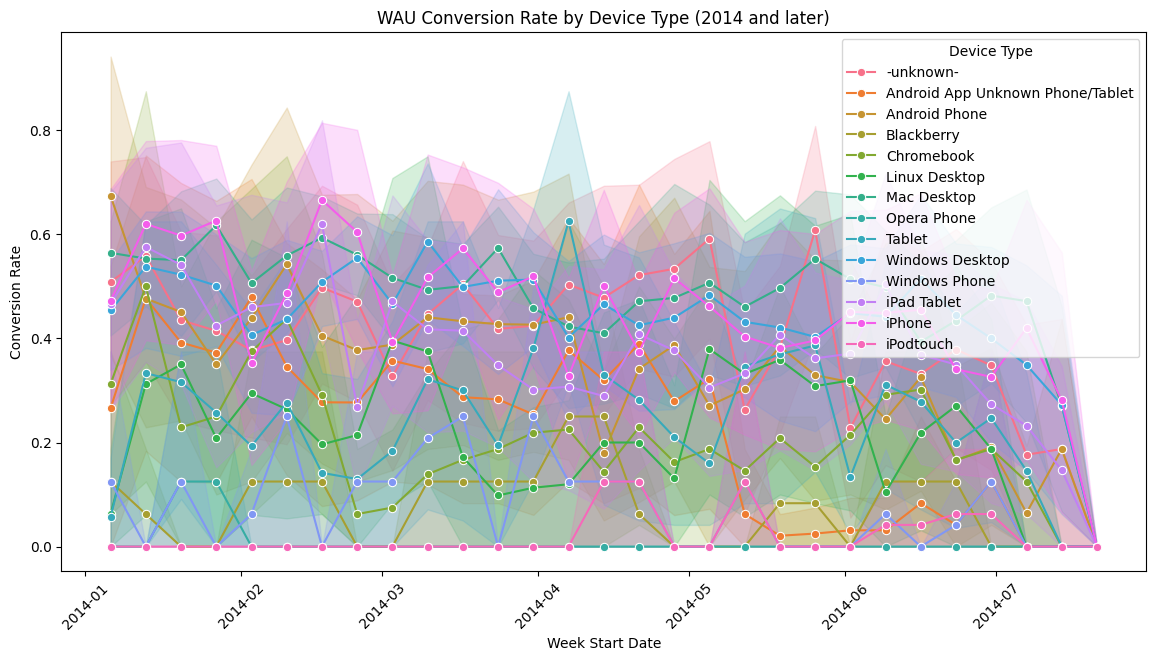

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜 데이터를 datetime 형식으로 변환
wau_pivot['week_start'] = pd.to_datetime(wau_pivot['week_start'])

# 2014년 이후의 데이터 필터링
wau_pivot_2014 = wau_pivot[wau_pivot['week_start'] >= '2014-01-01']

# WAU 전환율 시각화 - Affiliate Channel별
plt.figure(figsize=(14, 7))
sns.lineplot(data=wau_pivot_2014, x='week_start', y='conversion_rate', hue='affiliate_channel', marker='o')
plt.title('WAU Conversion Rate by Affiliate Channel (2014 and later)')
plt.xlabel('Week Start Date')
plt.ylabel('Conversion Rate')
plt.legend(title='Affiliate Channel')
plt.xticks(rotation=45)
plt.show()

# device type별 WAU 전환율 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(data=wau_pivot_2014, x='week_start', y='conversion_rate', hue='device_type', marker='o')
plt.title('WAU Conversion Rate by Device Type (2014 and later)')
plt.xlabel('Week Start Date')
plt.ylabel('Conversion Rate')
plt.legend(title='Device Type')
plt.xticks(rotation=45)
plt.show()

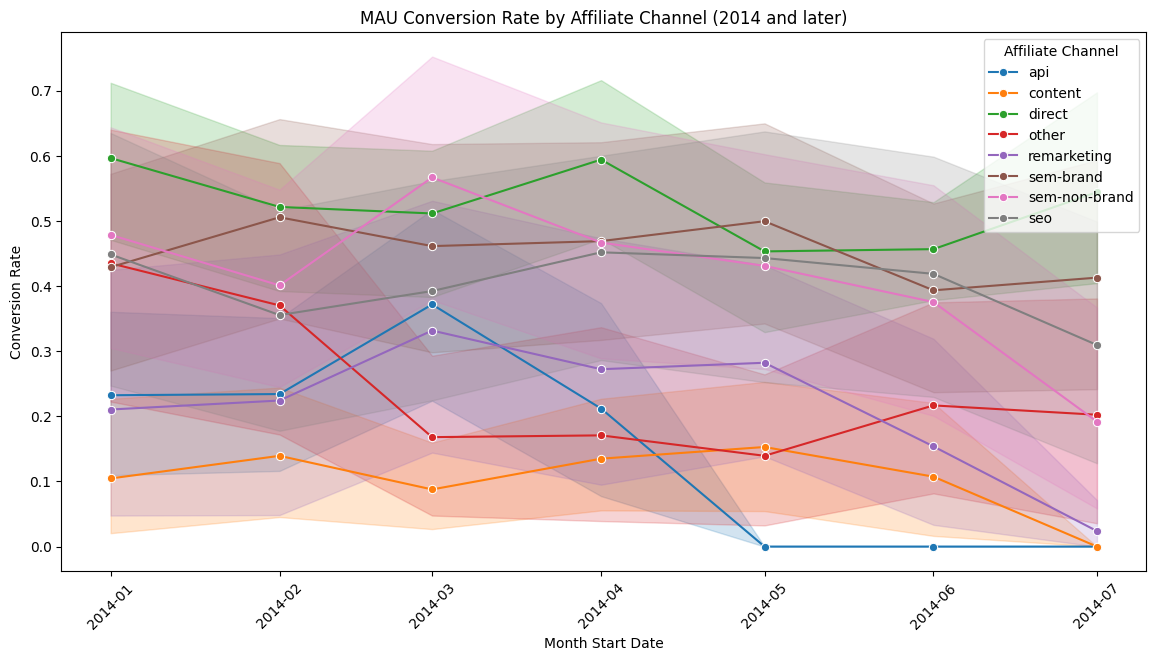

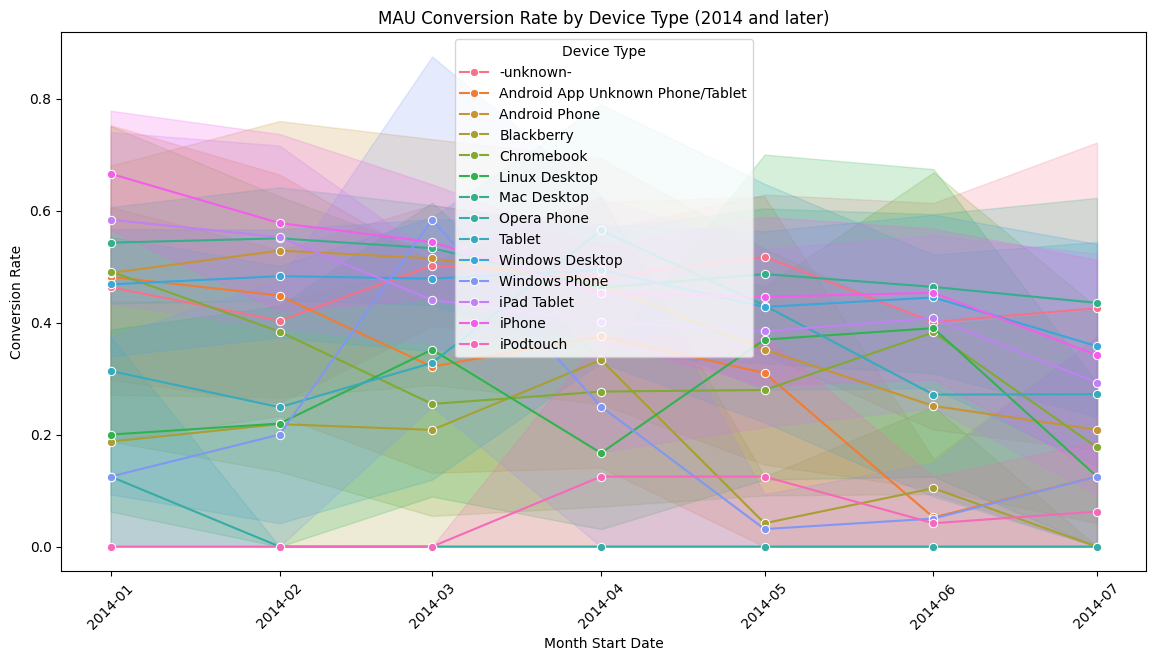

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜 데이터를 datetime 형식으로 변환
mau_pivot['month_start'] = pd.to_datetime(mau_pivot['month_start'])

# 2014년 이후의 데이터 필터링
mau_pivot_2014 = mau_pivot[mau_pivot['month_start'] >= '2014-01-01']

# MAU 전환율 시각화 - Affiliate Channel별
plt.figure(figsize=(14, 7))
sns.lineplot(data=mau_pivot_2014, x='month_start', y='conversion_rate', hue='affiliate_channel', marker='o')
plt.title('MAU Conversion Rate by Affiliate Channel (2014 and later)')
plt.xlabel('Month Start Date')
plt.ylabel('Conversion Rate')
plt.legend(title='Affiliate Channel')
plt.xticks(rotation=45)
plt.show()

# device type별 MAU 전환율 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(data=mau_pivot_2014, x='month_start', y='conversion_rate', hue='device_type', marker='o')
plt.title('MAU Conversion Rate by Device Type (2014 and later)')
plt.xlabel('Month Start Date')
plt.ylabel('Conversion Rate')
plt.legend(title='Device Type')
plt.xticks(rotation=45)
plt.show()

너무 복잡하여 해석이 불가능
상위 예약 전환율의 수치만 제공

In [18]:
import pandas as pd

# DAU 데이터의 2014년 이후 데이터 필터링
dau_pivot['date'] = pd.to_datetime(dau_pivot['date'])
dau_pivot_2014 = dau_pivot[dau_pivot['date'] >= '2014-01-01']

# 상위 5개의 affiliate channel과 device type 선정
top_5_affiliate_channels_dau = dau_pivot_2014.groupby('affiliate_channel')['conversion_rate'].mean().nlargest(5).index
top_5_device_types_dau = dau_pivot_2014.groupby('device_type')['conversion_rate'].mean().nlargest(5).index

# 상위 5개의 affiliate channel 및 device type 필터링된 데이터 추출
top_affiliate_data_dau = dau_pivot_2014[dau_pivot_2014['affiliate_channel'].isin(top_5_affiliate_channels_dau)]
top_device_data_dau = dau_pivot_2014[dau_pivot_2014['device_type'].isin(top_5_device_types_dau)]

# 상위 5개의 affiliate channel별 예약 전환율 평균 및 DAU 수치
affiliate_summary_dau = top_affiliate_data_dau.groupby('affiliate_channel').agg({
    'DAU_booked': 'sum',
    'DAU_not_booked': 'sum',
    'conversion_rate': 'mean'
}).reset_index()
affiliate_summary_dau = affiliate_summary_dau.sort_values(by='conversion_rate', ascending=False)

print("Top 5 Affiliate Channels by DAU Conversion Rate:")
print(affiliate_summary_dau)

# 상위 5개의 device type별 예약 전환율 평균 및 DAU 수치
device_summary_dau = top_device_data_dau.groupby('device_type').agg({
    'DAU_booked': 'sum',
    'DAU_not_booked': 'sum',
    'conversion_rate': 'mean'
}).reset_index()
device_summary_dau = device_summary_dau.sort_values(by='conversion_rate', ascending=False)

print("\nTop 5 Device Types by DAU Conversion Rate:")
print(device_summary_dau)


Top 5 Affiliate Channels by DAU Conversion Rate:
  affiliate_channel  DAU_booked  DAU_not_booked  conversion_rate
2            direct       62675           41031         0.407780
5         sem-brand       19440           13105         0.321561
7               seo        5034            2930         0.250129
6     sem-non-brand        6078            4515         0.239334
3             other        1212             855         0.125998
0               api           0               0              NaN
1           content           0               0              NaN
4       remarketing           0               0              NaN

Top 5 Device Types by DAU Conversion Rate:
                         device_type  DAU_booked  DAU_not_booked  \
6                        Mac Desktop       38804           23113   
9                    Windows Desktop       29200           19070   
12                            iPhone       11821            9954   
11                       iPad Tablet        5768  

In [19]:
import pandas as pd

# WAU 데이터의 2014년 이후 데이터 필터링
wau_pivot['week_start'] = pd.to_datetime(wau_pivot['week_start'])
wau_pivot_2014 = wau_pivot[wau_pivot['week_start'] >= '2014-01-01']

# 상위 5개의 affiliate channel과 device type 선정
top_5_affiliate_channels_wau = wau_pivot_2014.groupby('affiliate_channel')['conversion_rate'].mean().nlargest(5).index
top_5_device_types_wau = wau_pivot_2014.groupby('device_type')['conversion_rate'].mean().nlargest(5).index

# 상위 5개의 affiliate channel 및 device type 필터링된 데이터 추출
top_affiliate_data_wau = wau_pivot_2014[wau_pivot_2014['affiliate_channel'].isin(top_5_affiliate_channels_wau)]
top_device_data_wau = wau_pivot_2014[wau_pivot_2014['device_type'].isin(top_5_device_types_wau)]

# 상위 5개의 affiliate channel별 예약 전환율 평균 및 WAU 수치
affiliate_summary_wau = top_affiliate_data_wau.groupby('affiliate_channel').agg({
    'WAU_booked': 'sum',
    'WAU_not_booked': 'sum',
    'conversion_rate': 'mean'
}).reset_index()
affiliate_summary_wau = affiliate_summary_wau.sort_values(by='conversion_rate', ascending=False)

print("Top 5 Affiliate Channels by WAU Conversion Rate:")
print(affiliate_summary_wau)

# 상위 5개의 device type별 예약 전환율 평균 및 WAU 수치
device_summary_wau = top_device_data_wau.groupby('device_type').agg({
    'WAU_booked': 'sum',
    'WAU_not_booked': 'sum',
    'conversion_rate': 'mean'
}).reset_index()
device_summary_wau = device_summary_wau.sort_values(by='conversion_rate', ascending=False)

print("\nTop 5 Device Types by WAU Conversion Rate:")
print(device_summary_wau)


Top 5 Affiliate Channels by WAU Conversion Rate:
  affiliate_channel  WAU_booked  WAU_not_booked  conversion_rate
2            direct       31198           22029         0.458000
5         sem-brand        9586            6588         0.386828
7               seo        2478            1523         0.326313
6     sem-non-brand        2955            2295         0.319929
3             other         563             472         0.171715
0               api           0               0              NaN
1           content           0               0              NaN
4       remarketing           0               0              NaN

Top 5 Device Types by WAU Conversion Rate:
                         device_type  WAU_booked  WAU_not_booked  \
6                        Mac Desktop       17903           11240   
12                            iPhone        6796            5846   
9                    Windows Desktop       13329            9173   
0                          -unknown-        4743  

In [20]:
import pandas as pd

# MAU 데이터의 2014년 이후 데이터 필터링
mau_pivot['month_start'] = pd.to_datetime(mau_pivot['month_start'])
mau_pivot_2014 = mau_pivot[mau_pivot['month_start'] >= '2014-01-01']

# 상위 5개의 affiliate channel과 device type 선정
top_5_affiliate_channels_mau = mau_pivot_2014.groupby('affiliate_channel')['conversion_rate'].mean().nlargest(5).index
top_5_device_types_mau = mau_pivot_2014.groupby('device_type')['conversion_rate'].mean().nlargest(5).index

# 상위 5개의 affiliate channel 및 device type 필터링된 데이터 추출
top_affiliate_data_mau = mau_pivot_2014[mau_pivot_2014['affiliate_channel'].isin(top_5_affiliate_channels_mau)]
top_device_data_mau = mau_pivot_2014[mau_pivot_2014['device_type'].isin(top_5_device_types_mau)]

# 상위 5개의 affiliate channel별 예약 전환율 평균 및 MAU 수치
affiliate_summary_mau = top_affiliate_data_mau.groupby('affiliate_channel').agg({
    'MAU_booked': 'sum',
    'MAU_not_booked': 'sum',
    'conversion_rate': 'mean'
}).reset_index()
affiliate_summary_mau = affiliate_summary_mau.sort_values(by='conversion_rate', ascending=False)

print("Top 5 Affiliate Channels by MAU Conversion Rate:")
print(affiliate_summary_mau)

# 상위 5개의 device type별 예약 전환율 평균 및 MAU 수치
device_summary_mau = top_device_data_mau.groupby('device_type').agg({
    'MAU_booked': 'sum',
    'MAU_not_booked': 'sum',
    'conversion_rate': 'mean'
}).reset_index()
device_summary_mau = device_summary_mau.sort_values(by='conversion_rate', ascending=False)

print("\nTop 5 Device Types by MAU Conversion Rate:")
print(device_summary_mau)


Top 5 Affiliate Channels by MAU Conversion Rate:
  affiliate_channel  MAU_booked  MAU_not_booked  conversion_rate
2            direct       23107           17349         0.525360
5         sem-brand        7006            4948         0.452954
6     sem-non-brand        2119            1790         0.415901
7               seo        1817            1152         0.402755
3             other         410             351         0.243201
0               api           0               0              NaN
1           content           0               0              NaN
4       remarketing           0               0              NaN

Top 5 Device Types by MAU Conversion Rate:
                         device_type  MAU_booked  MAU_not_booked  \
12                            iPhone        5259            4677   
6                        Mac Desktop       12652            8309   
0                          -unknown-        4319            4971   
9                    Windows Desktop        9401  

In [ ]:
print("Timestamp first active range:", merged_data['timestamp_first_active'].min(), "to", merged_data['timestamp_first_active'].max())
print("Date first booking range:", merged_data['date_first_booking'].min(), "to", merged_data['date_first_booking'].max())


Timestamp first active range: 2014-01-01 00:09:36 to 2014-06-30 23:58:24
Date first booking range: 2014-01-01 00:00:00 to 2015-06-29 00:00:00
